In [1]:
import glob
import os
import json
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.mean import mean_covariance
from braindecode.datasets import BaseConcatDataset
from shutil import copyfile
from tqdm import tqdm
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, np_standardize

In [2]:
data_dir = "../data/vin/Official/"
als_data_dir = "../data/vin/Official/"

In [91]:
%%time
# fmt: off
subjects = [
    'K299', 'K300', 
    'K309', 'K310', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

# subjects = [
#     'K300', 'K309', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K320', 'K321', 
#     'K322', 'K323', 'K324', 'K325', 'K327', 
#     'K328', 'K329', 'K332', 'K335', 'K336', 
#     'K337', 'K338', 'K339', 'K354', 'K355', 
#     'K358', 'K359', 'K360', 'K361', 'K362', 
#     'K364', 'K366', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

# use_k_subjects = True  # @param {"type": "boolean"}
# use_bn_subjects = False  # @param {"type": "boolean"}

# subjects = list()
# if use_k_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("K")])
# if use_bn_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("BN")])

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

# subjects.remove("K324")

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

als_ds = load_data(
    als_data_dir,  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

ds = BaseConcatDataset([ds, als_ds])

# fmt: on

for _ds in ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"] == "K314":
        _ds_info["subject"] = "K314_t1"
    elif _ds_info["subject"] == "K324":
        _ds_info["subject"] = "K314_t2"

ds_info = ds.description

using 32 channels


subject:  36%|███▌      | 36/101 [00:00<00:00, 224.32it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  68%|██████▊   | 69/101 [00:03<00:02, 13.81it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  74%|███████▍  | 75/101 [00:04<00:02, 11.73it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s

CPU times: user 1min 24s, sys: 12.8 s, total: 1min 37s
Wall time: 1min 36s


In [92]:
ds_info

,subject,scenario,event,label,trial,split
0,K299,nâng tay trái,Thinking,nâng tay trái,0,train
1,K299,nâng tay trái,Resting,rest,0,train
2,K299,nâng tay trái,Resting,rest,1,train
3,K299,nâng tay trái,Thinking,nâng tay trái,1,train
4,K299,nâng tay trái,Resting,rest,2,train
...,...,...,...,...,...,...
3126,ALS02_t2,lắc đầu,Thinking,lắc đầu,0,train
3127,ALS02_t2,lắc đầu,Resting,rest,0,train
3128,ALS02_t2,lắc đầu,Thinking,lắc đầu,1,train
3129,ALS02_t2,lắc đầu,Resting,rest,1,train


In [93]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'gật đầu': 1,
 'há miệng': 2,
 'lắc đầu': 3,
 'nâng chân phải': 4,
 'nâng chân trái': 5,
 'nâng tay phải': 6,
 'nâng tay trái': 7}

In [94]:
evaluate_subjects = ds_info["subject"].unique()
print(evaluate_subjects)

n_subjects = len(evaluate_subjects)
n_subjects

['K299' 'K300' 'K309' 'K310' 'K311' 'K312' 'K313' 'K314_t1' 'K315' 'K316'
 'K319' 'K320' 'K321' 'K322' 'K323' 'K314_t2' 'K325' 'K326' 'K327' 'K328'
 'K329' 'K330' 'K331' 'K332' 'K333' 'K334' 'K335' 'K336' 'K337' 'K338'
 'K339' 'K340' 'K342' 'K343' 'K344' 'K350' 'K351' 'K352' 'K353' 'K354'
 'K355' 'K356' 'K357' 'K358' 'K359' 'K360' 'K361' 'K362' 'K363' 'K364'
 'K365' 'K366' 'K367' 'K368' 'K369' 'K370' 'K371' 'K372' 'K373' 'K374'
 'K375' 'ALS01_t1' 'ALS01_t2' 'ALS02_t1' 'ALS02_t2']


65

In [7]:
def riemann_alignment(C, Y, rest_label=0):
    R = mean_covariance(C[np.where(Y == rest_label)[0]], metric="riemann")
    R = linalg.inv(linalg.sqrtm(R))
    if np.iscomplexobj(R):
        R = np.real(R).astype(np.float32)
        
    C = R @ C @ R
    
    return C

In [96]:
est = Covariances(estimator="cov")

data = dict()
for subject in tqdm(evaluate_subjects, desc="subject", total=n_subjects):
    X = list()
    Y = list()
    for i in ds_info[ds_info["subject"] == subject].index:
        X.append(ds.datasets[i].windows.get_data())
        Y.append(np.array(ds.datasets[i].y, dtype=int))
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    C = est.transform(X)
    C = riemann_alignment(C, Y, rest_label=0)
    
    not_rest_idx = np.where(Y != 0)[0]
    data[subject] = (C[not_rest_idx], Y[not_rest_idx] - 1)

subject: 100%|██████████| 65/65 [01:14<00:00,  1.14s/it]


In [105]:
c, y = data["K299"]
c.shape, y.shape

((200, 32, 32), (200,))

In [106]:
%%time
accuracies = np.zeros((n_subjects, n_subjects), dtype=np.float32)
f1scores = np.zeros((n_subjects, n_subjects), dtype=np.float32)

# for tgt_i, tgt_subject in tqdm(enumerate(evaluate_subjects), desc="subject", total=n_subjects):
for tgt_i, tgt_subject in enumerate(evaluate_subjects):
    print(f"===========evaluating subject {tgt_subject}============")
    Cvalid, Yvalid = data[tgt_subject]
    
    for src_i, src_subject in tqdm(enumerate(evaluate_subjects), desc="subject", total=n_subjects):
        # clf = FgMDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1)
        clf = MDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1)
        
        try:
            Ctrain, Ytrain = data[src_subject]
            clf.fit(X=Ctrain, y=Ytrain)
        
            Ypred = clf.predict(Cvalid)

            acc = metrics.balanced_accuracy_score(y_true=Yvalid, y_pred=Ypred)
            f1 = metrics.f1_score(y_true=Yvalid, y_pred=Ypred, average="weighted")
            
        except Exception as e:
            print(f"tgt_subject: {tgt_subject} - src_subject: {src_subject}: failed: {e}")
            
            acc = 0
            f1 = 0

        accuracies[src_i, tgt_i] = acc
        f1scores[src_i, tgt_i] = f1
        
#         break
        
#     break

===========evaluating subject K299============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


===========evaluating subject K300============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


===========evaluating subject K309============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.72it/s]


===========evaluating subject K310============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.73it/s]


===========evaluating subject K311============


subject: 100%|██████████| 65/65 [00:15<00:00,  4.07it/s]


===========evaluating subject K312============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.68it/s]


===========evaluating subject K313============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


===========evaluating subject K314_t1============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.98it/s]


===========evaluating subject K315============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.74it/s]


===========evaluating subject K316============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]


===========evaluating subject K319============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


===========evaluating subject K320============


subject: 100%|██████████| 65/65 [00:15<00:00,  4.32it/s]


===========evaluating subject K321============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


===========evaluating subject K322============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.96it/s]


===========evaluating subject K323============


subject: 100%|██████████| 65/65 [00:16<00:00,  4.04it/s]


===========evaluating subject K314_t2============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.81it/s]


===========evaluating subject K325============


subject: 100%|██████████| 65/65 [00:18<00:00,  3.50it/s]


===========evaluating subject K326============


subject: 100%|██████████| 65/65 [00:18<00:00,  3.58it/s]


===========evaluating subject K327============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]


===========evaluating subject K328============


subject: 100%|██████████| 65/65 [00:15<00:00,  4.30it/s]


===========evaluating subject K329============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.97it/s]


===========evaluating subject K330============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


===========evaluating subject K331============


subject: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


===========evaluating subject K332============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.99it/s]


===========evaluating subject K333============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.81it/s]


===========evaluating subject K334============


subject: 100%|██████████| 65/65 [00:18<00:00,  3.58it/s]


===========evaluating subject K335============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]


===========evaluating subject K336============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]


===========evaluating subject K337============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


===========evaluating subject K338============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.78it/s]


===========evaluating subject K339============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


===========evaluating subject K340============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]


===========evaluating subject K342============


subject: 100%|██████████| 65/65 [00:16<00:00,  4.00it/s]


===========evaluating subject K343============


subject: 100%|██████████| 65/65 [00:15<00:00,  4.31it/s]


===========evaluating subject K344============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.71it/s]


===========evaluating subject K350============


subject: 100%|██████████| 65/65 [00:18<00:00,  3.42it/s]


===========evaluating subject K351============


subject: 100%|██████████| 65/65 [00:18<00:00,  3.56it/s]


===========evaluating subject K352============


subject: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]


===========evaluating subject K353============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.64it/s]


===========evaluating subject K354============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


===========evaluating subject K355============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.99it/s]


===========evaluating subject K356============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.82it/s]


===========evaluating subject K357============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.94it/s]


===========evaluating subject K358============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


===========evaluating subject K359============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.67it/s]


===========evaluating subject K360============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


===========evaluating subject K361============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


===========evaluating subject K362============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.81it/s]


===========evaluating subject K363============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.96it/s]


===========evaluating subject K364============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.98it/s]


===========evaluating subject K365============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


===========evaluating subject K366============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.75it/s]


===========evaluating subject K367============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


===========evaluating subject K368============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.82it/s]


===========evaluating subject K369============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


===========evaluating subject K370============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.98it/s]


===========evaluating subject K371============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.75it/s]


===========evaluating subject K372============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.95it/s]


===========evaluating subject K373============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.80it/s]


===========evaluating subject K374============


subject: 100%|██████████| 65/65 [00:17<00:00,  3.71it/s]


===========evaluating subject K375============


subject: 100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


===========evaluating subject ALS01_t1============


subject: 100%|██████████| 65/65 [00:19<00:00,  3.31it/s]


===========evaluating subject ALS01_t2============


subject: 100%|██████████| 65/65 [00:19<00:00,  3.27it/s]


===========evaluating subject ALS02_t1============


subject: 100%|██████████| 65/65 [00:19<00:00,  3.41it/s]


===========evaluating subject ALS02_t2============


subject: 100%|██████████| 65/65 [00:19<00:00,  3.40it/s]

CPU times: user 2min 9s, sys: 27.2 s, total: 2min 36s
Wall time: 18min 29s


<AxesSubplot:>

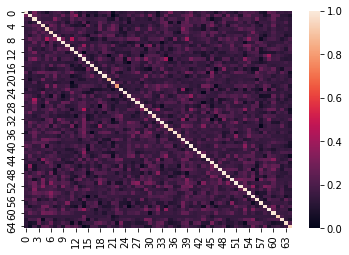

In [107]:
sb.heatmap(accuracies)

<AxesSubplot:>

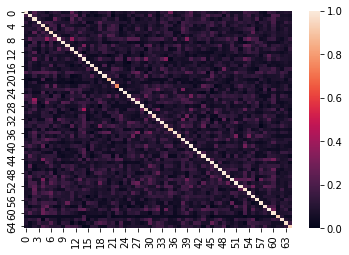

In [108]:
sb.heatmap(f1scores)

/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

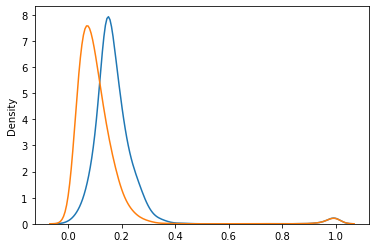

In [109]:
sb.distplot(accuracies, hist=False)
sb.distplot(f1scores, hist=False)

In [24]:
subject_id = {sub: i for i, sub in enumerate(evaluate_subjects)}

In [110]:
print([evaluate_subjects[i] for i in np.argsort(accuracies[subject_id["K309"]])[::-1]])

['K309', 'K314_t1', 'K366', 'K371', 'K354', 'K375', 'K320', 'K358', 'K343', 'K363', 'K322', 'K350', 'K331', 'K315', 'K356', 'K364', 'K368', 'K351', 'K369', 'K365', 'K323', 'K335', 'K340', 'K357', 'K327', 'K328', 'K310', 'K374', 'K299', 'K355', 'K321', 'K367', 'K326', 'K300', 'K370', 'K314_t2', 'K325', 'K352', 'ALS01_t1', 'K353', 'K313', 'K312', 'K342', 'K372', 'K337', 'K311', 'ALS02_t1', 'K316', 'K373', 'K333', 'K359', 'K338', 'K344', 'K319', 'K336', 'ALS01_t2', 'K362', 'ALS02_t2', 'K361', 'K332', 'K329', 'K339', 'K334', 'K330', 'K360']


In [111]:
for i, j in list(zip(*np.where(accuracies > 0.4))):
    if i == j:
        continue
    print(evaluate_subjects[i], evaluate_subjects[j])

K315 K312
K315 K320
K323 K344
K335 K309
K338 K323


In [112]:
src_subject = "K315"
tgt_subject = "K312"

print(src_subject, tgt_subject)

clf = MDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1)
        
try:
    Ctrain, Ytrain = data[src_subject]
    clf.fit(X=Ctrain, y=Ytrain)
        
    Cvalid, Yvalid = data[tgt_subject]
    Ypred = clf.predict(Cvalid)

    acc = metrics.balanced_accuracy_score(y_true=Yvalid, y_pred=Ypred)
    f1 = metrics.f1_score(y_true=Yvalid, y_pred=Ypred, average="weighted")
    
    print(acc)
    print(f1)
    print(metrics.confusion_matrix(y_true=Yvalid, y_pred=Ypred))
    print(metrics.classification_report(y_true=Yvalid, y_pred=Ypred))
    
except Exception as e:
    print(e)

K315 K312
0.42449479170448495
0.35917768013668705
[[ 0  2  4 29  1  2  2]
 [ 0  0  2 27  5  0  2]
 [ 0  0  1 21  7  0  0]
 [ 0  0  7 33  1  0  0]
 [ 0  0  0  0 26  5  0]
 [ 0  0  0  0  6 16 16]
 [ 0  0  0  0  3  3 41]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        36
           2       0.07      0.03      0.05        29
           3       0.30      0.80      0.44        41
           4       0.53      0.84      0.65        31
           5       0.62      0.42      0.50        38
           6       0.67      0.87      0.76        47

    accuracy                           0.45       262
   macro avg       0.31      0.42      0.34       262
weighted avg       0.33      0.45      0.36       262



/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'gật đầu': 1,
 'há miệng': 2,
 'lắc đầu': 3,
 'nâng chân phải': 4,
 'nâng chân trái': 5,
 'nâng tay phải': 6,
 'nâng tay trái': 7}

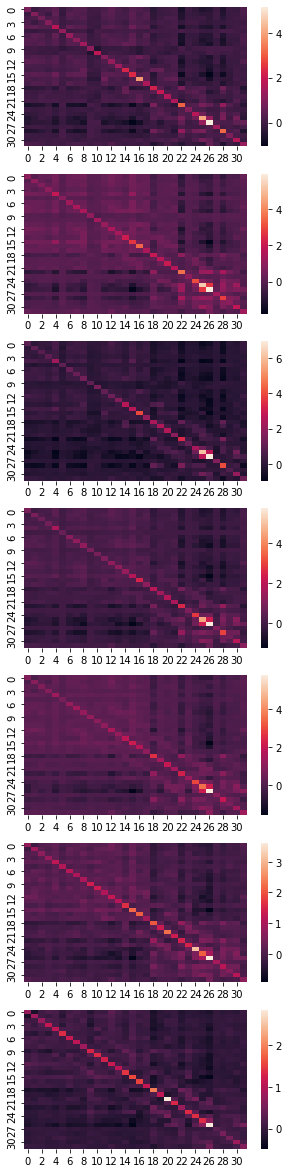

In [102]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(5, 21))

for i, c in enumerate(clf.covmeans_):
    sb.heatmap(c, ax=axes[i])

<AxesSubplot:>

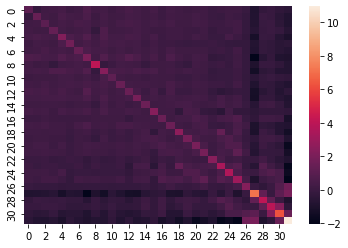

In [54]:
c, y = data["K338"]

sb.heatmap(c[np.where(y == 3)[0]].mean(axis=0))

<AxesSubplot:>

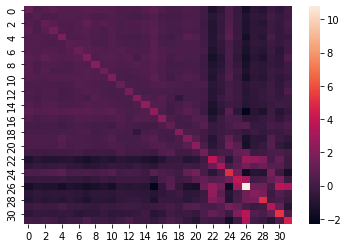

In [55]:
c, y = data["K323"]

sb.heatmap(c[np.where(y == 3)[0]].mean(axis=0))

In [148]:
x = ds.datasets[1].windows.get_data()
x.shape

(11, 32, 256)

In [161]:
x0 = x + 0.1 * np.random.normal(0.0, 5.0 * np.std(x, axis=-1, keepdims=True), x.shape)
x1 = x + 0.1 * np.random.normal(0.0, 2.0 * np.std(x, axis=-1, keepdims=True), x.shape)

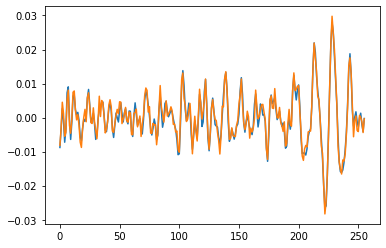

In [162]:
plt.plot(range(256), x[0, 0])
# plt.plot(range(256), x0[0, 0])
plt.plot(range(256), x1[0, 0])

In [164]:
np.random.normal(0.0, 5.0 * np.std(x, axis=-1, keepdims=True), x.shape).std(axis=-1)

array([[0.03588505, 0.03847936, 0.01915788, 0.02821043, 0.02477812,
        0.02480721, 0.02237374, 0.02058934, 0.02016273, 0.02266298,
        0.023621  , 0.02199278, 0.02208074, 0.02023764, 0.0191431 ,
        0.02381728, 0.02188174, 0.01802794, 0.01886081, 0.02094685,
        0.02209502, 0.02274201, 0.01867071, 0.01720212, 0.02264647,
        0.02127218, 0.01805105, 0.02127395, 0.02051397, 0.01998423,
        0.01987913, 0.01982909],
       [0.03507651, 0.03666176, 0.02162115, 0.02775878, 0.02552533,
        0.02201345, 0.02155019, 0.02057721, 0.01961979, 0.02298799,
        0.02379246, 0.01924278, 0.02059128, 0.01997858, 0.02106895,
        0.0222974 , 0.02105313, 0.01944157, 0.01950514, 0.01862659,
        0.02156253, 0.0224264 , 0.01649397, 0.01650987, 0.0229308 ,
        0.02260786, 0.0177895 , 0.01935229, 0.01832499, 0.01819071,
        0.0163228 , 0.02003428],
       [0.03682146, 0.04006802, 0.02334291, 0.02728299, 0.02820765,
        0.0248949 , 0.02685509, 0.02119792, 0.0202